In [1]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from functools import *

import pandas_ta as ta

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle
from scipy.signal import argrelextrema,argrelmin, argrelmax
from itertools import combinations


import sys, os
sys.path.append(os.path.abspath('..'))
from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

plt.rcParams['lines.linewidth'] = 1 

mpl.rcParams.update({'font.size': 10, 'lines.linewidth': 1, 'figure.dpi': 100})


In [2]:
# Create a DataFrame so 'ta' can be used.
df = pd.DataFrame()

# Help about this, 'ta', extension
# help(df.ta)
df.ta.indicators()
# df.a


Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [233]:
pair = 'BTC_USDT'
timeframe = '2H'
exchange = 'binance'

# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'

def load_candles(exchange, pair, timeframe):
    odf = pd.read_json(f'../freq-user-data/data/{exchange}/{pair}-{timeframe.lower()}.json'
    ).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
    # odf['dtime'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=True).dt.tz_localize(None)
    ).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=True).dt.tz_localize(None)
    ).set_index('dtime').sort_index().drop('timestamp', axis=1)
    return odf


In [234]:
# odf

### All candle stick patterns under the sun

In [235]:

odf = load_candles(exchange, pair, timeframe)
odf = odf.iloc[odf.shape[0] // 2:
               ]
lret = odf.close.divide(odf.open).apply(np.log)

cdls = odf.ta.cdl_pattern(name="all")
cdls.shape, cdls.head(5)
# odf.close.ewm(lag).std()

((12542, 62),
                      CDL_2CROWS  CDL_3BLACKCROWS  CDL_3INSIDE  \
 dtime                                                           
 2020-07-01 04:00:00         0.0              0.0          0.0   
 2020-07-01 06:00:00         0.0              0.0          0.0   
 2020-07-01 08:00:00         0.0              0.0          0.0   
 2020-07-01 10:00:00         0.0              0.0          0.0   
 2020-07-01 12:00:00         0.0              0.0          0.0   
 
                      CDL_3LINESTRIKE  CDL_3OUTSIDE  CDL_3STARSINSOUTH  \
 dtime                                                                   
 2020-07-01 04:00:00              0.0           0.0                0.0   
 2020-07-01 06:00:00              0.0           0.0                0.0   
 2020-07-01 08:00:00              0.0           0.0                0.0   
 2020-07-01 10:00:00              0.0           0.0                0.0   
 2020-07-01 12:00:00              0.0           0.0                0.0   
 
  

### Moving Averages and rolling standard deviations and z-score

In [113]:


edf = pd.DataFrame({
    k: v 
    
    for lag in [6,12,21,50]
    for edf in [odf.close.ewm(lag)]
    for rdf in [odf.close.rolling(lag)]
    for [emean,estd] in [[edf.mean(), edf.std()]]
    for [rmean,rstd] in [[rdf.mean(), rdf.std()]]
    for k, v in [
        (f'ema_{lag}' , emean),
        (f'estd_{lag}' , estd),
        (f'eZscore', (odf.close - emean) / estd),
        (f'rma_{lag}' , rmean),
        (f'rstd_{lag}' , rstd),
        (f'rZscore', (odf.close - rmean) / rstd)
    ]

})
edf.shape, edf 

((12542, 18),
                                   ema_6      estd_6   eZscore         rma_6  \
 dtime                                                                         
 2020-07-01 04:00:00+00:00   9142.620000         NaN       NaN           NaN   
 2020-07-01 06:00:00+00:00   9138.716154    5.126524 -0.700106           NaN   
 2020-07-01 08:00:00+00:00   9148.853307   16.107370  1.106512           NaN   
 2020-07-01 10:00:00+00:00   9151.996706   13.744240  0.600278           NaN   
 2020-07-01 12:00:00+00:00   9167.938669   31.904837  1.604268           NaN   
 ...                                 ...         ...       ...           ...   
 2023-05-12 10:00:00+00:00  26737.943723  472.576100 -1.732770  26463.321667   
 2023-05-12 12:00:00+00:00  26696.808906  449.914016 -1.561545  26391.908333   
 2023-05-12 14:00:00+00:00  26643.099062  438.470024 -1.641971  26347.995000   
 2023-05-12 16:00:00+00:00  26594.726339  424.264430 -1.600419  26352.631667   
 2023-05-12 18:00:00+00:00

In [114]:
edf.columns.tolist()


['ema_6',
 'estd_6',
 'eZscore',
 'rma_6',
 'rstd_6',
 'rZscore',
 'ema_12',
 'estd_12',
 'rma_12',
 'rstd_12',
 'ema_21',
 'estd_21',
 'rma_21',
 'rstd_21',
 'ema_50',
 'estd_50',
 'rma_50',
 'rstd_50']

### Past plen periods flattened to current row

In [265]:
def flatten_past_n(odf, nper=None):
# plen = 6 * 2
    # if columns is None: columns = odf.columns.tolist()
    pcols = [f'{c}_m{nper-j}' for c in odf.columns for j in range(nper)]
    fdf = pd.DataFrame([
        (
            odf.iloc[i-nper:i].values.flatten()
        )
        #.shape
        for prange in [range(nper,odf.shape[0])]
        for i in prange
    ], index=odf.index.values[nper:]).set_axis(pcols, axis=1)

    return fdf

flatten_past_n(odf.iloc[:100][['high']], nper=4)#.index
# xdf = odf.join(fdf)#.join(edf)

# xdf[odf.columns.tolist() + [f'{c}_m{j}' for c in odf.columns for j in range(1,3) ]].tail()

,high_m4,high_m3,high_m2,high_m1
2020-07-01 12:00:00,9162.85,9158.00,9200.00,9175.00
2020-07-01 14:00:00,9158.00,9200.00,9175.00,9254.00
2020-07-01 16:00:00,9200.00,9175.00,9254.00,9268.38
2020-07-01 18:00:00,9175.00,9254.00,9268.38,9292.00
2020-07-01 20:00:00,9254.00,9268.38,9292.00,9283.16
...,...,...,...,...
2020-07-09 02:00:00,9445.00,9445.00,9468.00,9440.79
2020-07-09 04:00:00,9445.00,9468.00,9440.79,9406.16
2020-07-09 06:00:00,9468.00,9440.79,9406.16,9405.88
2020-07-09 08:00:00,9440.79,9406.16,9405.88,9419.61


In [226]:
# xdf.columns.tolist()

### Higher timeframes

In [238]:

H_periods = ['4H', '8H', '1D', '3D', '1W-Mon', '2W-Mon', '1M', 'Q', '1Y']
H_odfs = {
    timeframe: odf,
    **{period: odf.resample(period, closed='left', label='left').agg(OrderedDict([
        ('open', 'first'),
        ('high', 'max'),
        ('low', 'min'),
        ('close', 'last'),
        ('volume', 'sum'),
    ])).set_axis([f'H_{period}_{c}' for c in odf.columns], axis=1)
    for period in H_periods #[p.replace('-','_') for p in H_periods]
    }
}
# hdf = reduce(lambda x,y: pd.merge_asof(x,y, direction='backward', left_index=True, right_index=True) ,
#     [odf] + H_odfs)#.drop('dTime')
# hdf['2023-05-01':].head()

hdf = reduce(lambda x,y: pd.merge_asof(x,y, direction='backward', left_index=True, right_index=True) ,
    H_odfs.values())
hdf.columns.tolist()


['open',
 'high',
 'low',
 'close',
 'volume',
 'H_4H_open',
 'H_4H_high',
 'H_4H_low',
 'H_4H_close',
 'H_4H_volume',
 'H_8H_open',
 'H_8H_high',
 'H_8H_low',
 'H_8H_close',
 'H_8H_volume',
 'H_1D_open',
 'H_1D_high',
 'H_1D_low',
 'H_1D_close',
 'H_1D_volume',
 'H_3D_open',
 'H_3D_high',
 'H_3D_low',
 'H_3D_close',
 'H_3D_volume',
 'H_1W-Mon_open',
 'H_1W-Mon_high',
 'H_1W-Mon_low',
 'H_1W-Mon_close',
 'H_1W-Mon_volume',
 'H_2W-Mon_open',
 'H_2W-Mon_high',
 'H_2W-Mon_low',
 'H_2W-Mon_close',
 'H_2W-Mon_volume',
 'H_1M_open',
 'H_1M_high',
 'H_1M_low',
 'H_1M_close',
 'H_1M_volume',
 'H_Q_open',
 'H_Q_high',
 'H_Q_low',
 'H_Q_close',
 'H_Q_volume',
 'H_1Y_open',
 'H_1Y_high',
 'H_1Y_low',
 'H_1Y_close',
 'H_1Y_volume']

### Flatten N-number of past rows over higher time-frames

In [270]:
h_flats = [('2H', 12 * 7 * 2), ('4H', 6*7 * 2), ('8H', 3*7* 2), ('1D', 30 * 2 ), ('3D', 30), ('1W-Mon', 4 * 4), ('2W-Mon', 2*3), ('1M', 3*2), ('Q', 4*2), ('1Y',2)]

FH_dfs = {
    timeframe: flatten_past_n(H_odfs[timeframe], nper=nper)
    for timeframe, nper in h_flats
}
FH_dfs

fhdf = reduce(lambda df1,df2: pd.merge_asof(df1,df2, direction='backward', left_index=True, right_index=True) ,
    [FH_dfs[tf] for (tf, nper) in h_flats]
)
fhdf.head()

,open_m168,open_m167,open_m166,open_m165,open_m164,open_m163,open_m162,open_m161,open_m160,open_m159,...,H_1Y_open_m2,H_1Y_open_m1,H_1Y_high_m2,H_1Y_high_m1,H_1Y_low_m2,H_1Y_low_m1,H_1Y_close_m2,H_1Y_close_m1,H_1Y_volume_m2,H_1Y_volume_m1
2020-07-15 04:00:00,9138.55,9162.85,9131.00,9142.62,1868.048354,9142.61,9158.00,9125.31,9135.37,2418.157938,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-15 06:00:00,9142.61,9158.00,9125.31,9135.37,2418.157938,9135.37,9200.00,9135.02,9164.99,3991.529915,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-15 08:00:00,9135.37,9200.00,9135.02,9164.99,3991.529915,9164.46,9175.00,9133.10,9158.98,2944.134982,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-15 10:00:00,9164.46,9175.00,9133.10,9158.98,2944.134982,9159.06,9254.00,9135.07,9211.96,5902.212700,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-15 12:00:00,9159.06,9254.00,9135.07,9211.96,5902.212700,9211.96,9268.38,9207.92,9263.94,4611.946929,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
fhdf.columns.tolist()

In [212]:

def plot_candles(wdf, ax=None, kwargs={}):
    if ax is None:
        fig, ax = plt.subplots(**kwargs)

    up, down = wdf[wdf.close >= wdf.open], wdf[wdf.close < wdf.open]
    col1,col2 = 'green','red'
    width, width2 = .8, .1
    # Plotting up prices of the stock
    ax.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
    ax.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
    ax.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)
    # Plotting down prices of the stock
    ax.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
    ax.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
    ax.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)    
    plt.xticks(rotation=30, ha='right')
    return ax

def plot_H_candles(wdf, ax=None, columns=['open', 'high', 'low', 'close'], column_prefix='', column_suffix='', n_spans=1., alpha=0.3, align='edge', kwargs={}):
    if ax is None:
        fig, ax = plt.subplots(**kwargs)
        
    copen, chigh, clow, cclose = [f'{column_prefix}{c}{column_suffix}' for c in columns]
    up, down = wdf[wdf[cclose] >= wdf[copen]], wdf[wdf[cclose] < wdf[copen]]
    col1,col2 = 'green','red'
    width, width2 = n_spans * 1.,  .02 * n_spans

    # # Plotting up prices of the stock
    ax.bar(up.index.values, up[cclose]-up[copen], width, bottom=up[copen], color=col1, alpha=alpha, align=align)
    ax.bar(up.index.values, up[chigh]-up[cclose], width, bottom=up[cclose], color=col1, alpha=alpha * 0.3, align=align)
    ax.bar(up.index.values, up[clow]-up[copen], width, bottom=up[copen], color=col1, alpha=alpha* 0.3, align=align)
    # # Plotting down prices of the stock
    ax.bar(down.index.values, down[cclose]-down[copen], width, bottom=down[copen], color=col2, alpha=alpha, align=align)
    ax.bar(down.index.values, down[chigh]-down[copen], width, bottom=down[copen], color=col2, alpha=alpha*0.3, align=align)
    ax.bar(down.index.values, down[clow]-down[cclose], width, bottom=down[cclose], color=col2, alpha=alpha*0.3, align=align)   
    return ax

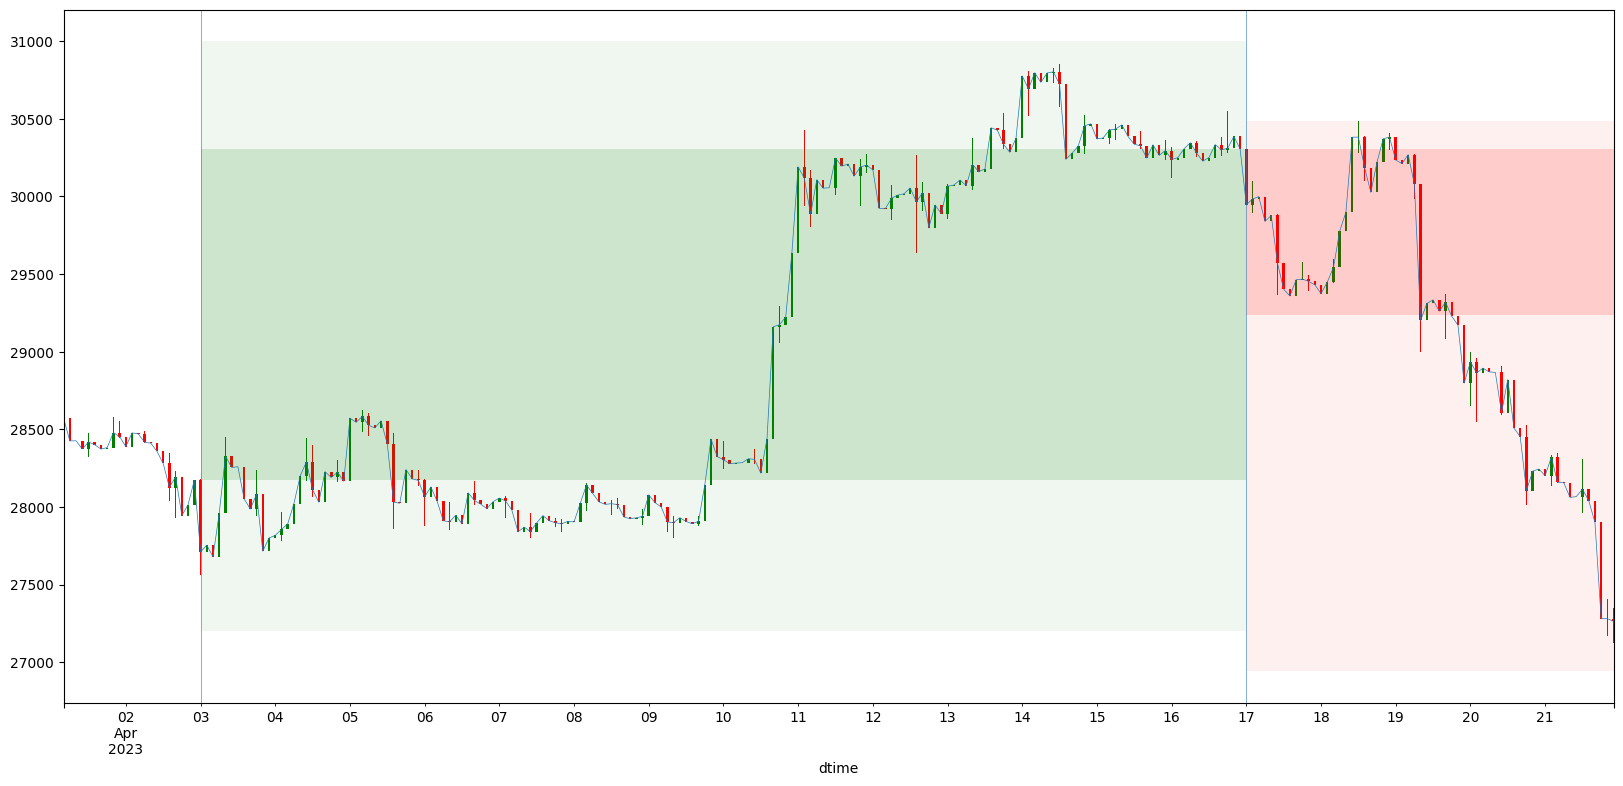

In [214]:
gdf = hdf[-500:-250]
ax = gdf.close.plot(figsize=(20,9), lw=0.5)

ghdf = H_odfs[3].loc[gdf.index[0]:gdf.index[-1]]
plot_candles(gdf, ax=ax)
plot_H_candles(ghdf, ax=ax, column_prefix='H_2W-Mon_', n_spans=24*7.*2, alpha=0.2)

for h in ghdf.index.values: ax.axvline(h, lw=0.4)


In [99]:


wlen = 6 * 2

fdf = pd.DataFrame([
    (
        odf.iloc[i-wlen:i].values.flatten()
    )
    #.shape
    for i in range(wlen,odf.shape[0])
], index=odf.index.values[wlen:])

xdf = odf.join(fdf).join(edf).dropna()

xdf.columns


timeout = 6

#################
# fu_highs = dxdf.high.rolling(timeout).max().shift(-timeout)
# fu_high_rets = fu_highs.divide(dxdf.close).apply(np.log).fillna(0).round(3)
# fu_lows = dxdf.low.rolling(timeout).min().shift(-timeout)
# fu_low_rets = fu_lows.divide(dxdf.close).apply(np.log).fillna(0).round(3)
#################

fu_highs = xdf.close.rolling(timeout).max().shift(-timeout)
fu_high_rets = fu_highs.divide(xdf.close).apply(np.log).fillna(0).round(3)
fu_lows = xdf.close.rolling(timeout).min().shift(-timeout)
fu_low_rets = fu_lows.divide(xdf.close).apply(np.log).fillna(0).round(3)
fu_r2r = - fu_low_rets / fu_high_rets
# fu_rets
# qs = np.quantile(fu_rets, np.linspace(0,1,6))
# y_cut, y_bins = pd.qcut(fu_rets, np.linspace(0,1,8), retbins=True)
# y = y_cut.map(lambda x: x.right).astype(float).values 
cats = pd.DataFrame(
    (fu_high_rets > 0.025)
        # (fu_rets >= target_ret) & (fu_dds >= sl_ret)
        # fu_lows < ema - stds * 3
    & ((- fu_low_rets / fu_high_rets) < 1/2.5)
        # np.where( fu_r2r < 1/2.5 , 1, np.where(fu_r2r > 2.5, 1, 0))
        # & (fu_low_rets > 0.01)
        # fu_low_rets > -0.01
     , index=xdf.index).dropna()#.astype(str)


wsel = cats.shape[0] // 2
sel_cats = cats.iloc[wsel:]
y = sel_cats.values.ravel()
X = xdf.loc[sel_cats.index].values

# iX_train, iX_test, y_train, y_test = train_test_split(i_samples, y, random_state=1, test_size=0.8)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.2)

clf = MLPClassifier(solver='adam', max_iter=500, verbose=False, batch_size=1024, 
                    activation='relu', epsilon=1e-10, hidden_layer_sizes=(60,60,60)
                #     learning_rate_init = 1e-4,
                    )

scaler = StandardScaler().fit(X)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

m = clf.fit(X_train_norm, y_train)



y_pred_train =  m.predict(X_train_norm)
y_pred_test =  m.predict(X_test_norm)

accuracy_train = accuracy_score(y_train,y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
# y_pred_proba = m.predict_proba(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
# auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
# fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba[:,1])

# print('ROC curve (area = {:0.2f})'.format(auc_score))
print(f'Acc(train)={accuracy_train:.2f}\tAcc(test)={accuracy_train:.2f}')
print(f'Precision(Train)={precision_train:.2f}\tRecall(Train)={recall_train:.2f}')
print(f'Precision(Test)={precision_test:.2f}\tRecall(Test)={recall_test:.2f}')
print(f'----------- Classification Report: ------------')
report = classification_report(y_test, y_pred_test)
print(report)

Acc(train)=0.98	Acc(test)=0.98
Precision(Train)=0.95	Recall(Train)=0.85
Precision(Test)=0.40	Recall(Test)=0.31
----------- Classification Report: ------------
              precision    recall  f1-score   support

       False       0.93      0.95      0.94      1134
        True       0.40      0.31      0.35       116

    accuracy                           0.89      1250
   macro avg       0.67      0.63      0.65      1250
weighted avg       0.88      0.89      0.89      1250



In [98]:

# sel_cats = cats.iloc[:wsel]
test_cats = cats.iloc[wsel:]
y_test = test_cats.values
X_test = xdf.loc[test_cats.index].values

# scaler = StandardScaler().fit(X_test)

# X_train_norm = StandardScaler().fit(X_test).transform(X_train)

X_train_norm = scaler.transform(X_train)

X_test_norm = scaler.transform(X_test)
y_pred_test =  m.predict(X_test_norm)


accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
print(f'Precision(Test)={precision_test:.2f}\tRecall(Test)={recall_test:.2f}')
print(f'----------- Classification Report: ------------')
report = classification_report(y_test, y_pred_test)
print(report)

Precision(Test)=0.11	Recall(Test)=0.41
----------- Classification Report: ------------
              precision    recall  f1-score   support

       False       0.90      0.62      0.73      5588
        True       0.11      0.41      0.18       659

    accuracy                           0.60      6247
   macro avg       0.51      0.51      0.46      6247
weighted avg       0.82      0.60      0.68      6247



In [38]:
def print(i):
    j = iX_test[i]
    wdf = odf.iloc[j - wlen:j + timeout].copy()
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.subplots(1,1)
    ax1.axvline(odf.index[j])
    # plot_candles(wdf,ax=ax1)
    wdf.close.plot(ax=ax1, color='red' if y_pred_test[i] else 'gray')

interactive(print, i=(0,iX_test.shape[0]))

interactive(children=(IntSlider(value=819, description='i', max=1639), Output()), _dom_classes=('widget-intera…

In [100]:
256 * 128 *128

4194304

In [102]:
7 * 7 * 128 * 3

18816